In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengolib
import numpy as np
import pandas as pd
import random
import scipy as sp
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

import pytry

In [6]:
class PatternInterpolationTrial(pytry.Trial):
    def params(self):
        self.param('number of dimensions', n_dims=2),
        self.param('length of pattern', len_train=10),
        
    def evaluate(self, param): #function to fill in missing data points by interpolating
        import nengo
        data = pd.read_csv("pinsoro-2017-06-20-145454904791-small.csv", low_memory=False)
        
        x = np.array(data.iloc[:,11:195]).astype(float) #array of data for purple child (points in space for each frame)
        labs = np.array(data.iloc[:,218]).astype(str) #array of labels (purple child annotations, engagement)
        a = []
        for i in range(x.shape[1]):
            y = pd.Series(x[:,i])
            z = y.interpolate(limit_direction='both')
            a.append(z)
        a = pd.DataFrame(a)
        a = a.dropna()
        a = np.array(a).T
        
        dt = 0.001
        target_dt = 1.0/30
        D = param.n_dims
        classify_score = {}
        accuracy = {}
        classification = {}
        
        def extract_pattern(start, end, target_dt): #function to extract consecutive frames with the same label 
            pattern = np.array(a[start:end,:]).astype(float)
            frames = np.array(data.iloc[start:end,9]).astype(int)

            good_indices = frames != -1
            frames = frames[good_indices]
            pattern = pattern[good_indices]

            fps = 30.0
            t_sample = (frames - frames[0])/fps

            t = np.arange(int(t_sample[-1]/target_dt))*target_dt

            result = []
            for i in range(pattern.shape[1]):       
                p = np.interp(t, t_sample, pattern[:,i])
                result.append(p)
            result = np.array(result).T

            return t, result

        start=[]
        start.append(0)
        end=[]
        label = []
        for i in range(1, (len(labs)-1)):
            if labs[i]!=labs[i-1]:
                start.append(i)
            if labs[i]!=labs[i+1]:
                end.append(i)
                label.append(labs[i])

        t_noplay=[]
        p_noplay=[]
        t_goal=[]
        p_goal=[]
        t_aim=[]
        p_aim=[]
        
        for i in range(1,(len(start)-1)):
            if label[i]==('noplay'):
                ti, pi = extract_pattern(start[i], end[i], target_dt=target_dt)
                t_noplay.append(ti)
                p_noplay.append(pi)
            if label[i]==('goaloriented'):
                ti, pi = extract_pattern(start[i], end[i], target_dt=target_dt)
                t_goal.append(ti)
                p_goal.append(pi)
            if label[i]==('aimless'):
                ti, pi = extract_pattern(start[i], end[i], target_dt=target_dt)
                t_aim.append(ti)
                p_aim.append(pi)
        
############ randomly split data 80/20 into training and testing sets ############ 
        p_goal = random.sample(p_goal, len(p_goal))
        goal_train = p_goal[:(int(len(p_goal)*0.8))] 
        goal_test = p_goal[(int(len(p_goal)*0.8)):]

        p_noplay = random.sample(p_noplay, len(p_noplay))
        noplay_train = p_noplay[:(int(len(p_noplay)*0.8))]
        noplay_test = p_noplay[(int(len(p_noplay)*0.8)):]

        train_all = np.vstack(goal_train+noplay_train)
        pca_model = PCA(n_components=D).fit(train_all)

        goal_train_pca = np.vstack([pca_model.transform(p) for p in goal_train])
        noplay_train_pca = np.vstack([pca_model.transform(p) for p in noplay_train])
        goal_test_pca = np.vstack([pca_model.transform(p) for p in goal_test])
        noplay_test_pca = np.vstack([pca_model.transform(p) for p in noplay_test])

        T_train = param.len_train   # number of seconds to train on for each class
        T_test = param.len_train    # number of seconds to test on for each class

        N_frames = int(T_train*30)
        training = np.vstack([goal_train_pca[:N_frames], noplay_train_pca[:N_frames]])
        assert len(training) == N_frames*2

        N_frames = int(T_test*30)
        testing = np.vstack([goal_test_pca[:N_frames], noplay_test_pca[:N_frames]])
        assert len(testing) == N_frames*2
        
############ TRAINING WITH 80% ############ 

        theta = 0.5
        net = nengo.Network()
        with net:
            process = nengo.processes.WhiteSignal(period=100., high=3.0, y0=0)
            rw = []
            for i in range(D):
                rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                          process=process, 
                                                          neuron_type=nengo.LIFRate()))


            node_pool = nengo.Node(None, size_in=rw[0].state.size_out*D)

            start = 0
            for r in rw:
                nengo.Connection(r.state, node_pool[start:start+r.state.size_out])
                start += r.state.size_out



            stim = nengo.Node(nengo.processes.PresentInput(training, presentation_time=1.0/30))
            assert stim.size_out == D
            for i in range(D):
                nengo.Connection(stim[i], rw[i].input, synapse=None)

            p_node_pool = nengo.Probe(node_pool)


        sim = nengo.Simulator(net)
        with sim:
            sim.run(T_train*2) 
        
        pool_model = nengo.Network()
        with pool_model:
            pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                                  neuron_type=nengo.LIFRate(), seed=1)
        pool_sim = nengo.Simulator(pool_model)

        import nengo.utils.ensemble

        _, a = nengo.utils.ensemble.tuning_curves(pool, pool_sim, inputs=sim.data[p_node_pool])


        N = int(T_train*1000)
        target = np.hstack([np.ones(N), -np.ones(N)]).reshape(-1, 1)
        dec, info = nengo.solvers.LstsqL2(reg=0.1)(a, target)
        
        v = np.dot(a, dec)
        classify1 = np.isclose(v[:N], 1, atol=0.5)
        classify2 = np.isclose(v[N:], -1, atol=0.5)
        classify = np.append(classify1, classify2)
        score_train = np.mean(classify)
        
        classify_score[0]=score_train
        
        plt.plot(sim.trange(), classify)
        plt.plot(sim.trange(), v)
        plt.axvline(T_train, ls=':')
        plt.title('training classification accuracy: %1.2f%%' % (score_train*100))
        
        #accuracy_train={}
        #for i in range(len(v)):
        #    accuracy_train[i]=float(v[i])
        
        #for j in range(len(accuracy_aim)):
        #    key_j = 'accuracy_train{}'.format(j)  
        #    accuracy_train[key_j] = accuracy_train.pop(j)

############ TESTING WITH 20% ############ 

        D = param.n_dims

        theta = 0.5
        test_net = nengo.Network()
        with test_net:
            process = nengo.processes.WhiteSignal(period=100., high=3.0, y0=0)
            rw = []
            for i in range(D):
                rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                          process=process, 
                                                          neuron_type=nengo.LIFRate()))


            pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                                  neuron_type=nengo.LIFRate(), seed=1)

            start = 0
            for r in rw:
                nengo.Connection(r.state, pool[start:start+r.state.size_out])
                start += r.state.size_out



            stim = nengo.Node(nengo.processes.PresentInput(training, presentation_time=1.0/30))
            assert stim.size_out == D
            for i in range(D):
                nengo.Connection(stim[i], rw[i].input, synapse=None)

            p_stim = nengo.Probe(stim)

            result = nengo.Node(None, size_in=1)
            nengo.Connection(pool.neurons, result, transform=dec.T, synapse=None)

            p_test_result = nengo.Probe(result)
            p_test_result_sample = nengo.Probe(result, sample_every = 0.01)


        test_sim = nengo.Simulator(test_net)
        test_sim.run(T_test*2) 
        
        N = int(T_test*1000)

        v = test_sim.data[p_test_result]
        classify1 = np.isclose(v[:N], 1, atol=0.5)
        classify2 = np.isclose(v[N:], -1, atol=0.5)
        classify = np.append(classify1, classify2)
        score_test = np.mean(classify)
        
        classify_score[1]=score_test
        
        plt.plot(test_sim.trange(), classify)
        plt.plot(test_sim.trange(), v)
        plt.axvline(T_test, ls=':')
        plt.title('testing classification accuracy: %1.2f%%' % (score_test*100))
        
        accuracy_test={}
        for i in range(len(v)):
            accuracy_test[i]=float(v[i])
        
        for j in range(len(accuracy_test)):
            key_j = 'accuracy_test{}'.format(j)  
            accuracy_test[key_j] = accuracy_test.pop(j)

############ TRAINING WITH AIMLESS PATTERNS ############ 

        p_aim = random.sample(p_aim, len(p_aim))

        aimless_patterns1 = {}
        aimless_patterns2 = {}
        i=0
        for ap in p_aim:
            aimless_patterns1[i] = pca_model.transform(ap)[:,0]
            aimless_patterns2[i] = pca_model.transform(ap)[:,1]
            i+=1

        N_frames = int(T_test*30)

        test_aim1 = np.array(aimless_patterns1[0])
        for ap in range(1,(len(aimless_patterns1))):
            test_aim1 = np.hstack([test_aim1,aimless_patterns1[ap]])
        test_aim1 = test_aim1[:N_frames]

        test_aim2 = np.array(aimless_patterns2[0])
        for ap in range(1,(len(aimless_patterns2))):
            test_aim2 = np.hstack([test_aim2,aimless_patterns2[ap]])
        test_aim2 = test_aim2[:N_frames]
        
        test_aim = np.vstack([test_aim1[:N_frames], test_aim2[:N_frames]]).T
        assert len(test_aim) == N_frames
        
        
        theta = 0.5
        aim_test_net = nengo.Network()
        with aim_test_net:
            process = nengo.processes.WhiteSignal(period=100., high=3.0, y0=0)
            rw = []
            for i in range(D):
                rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                          process=process, 
                                                          neuron_type=nengo.LIFRate()))


            pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                                  neuron_type=nengo.LIFRate(), seed=1)

            start = 0
            for r in rw:
                nengo.Connection(r.state, pool[start:start+r.state.size_out])
                start += r.state.size_out



            stim = nengo.Node(nengo.processes.PresentInput(test_aim, presentation_time=1.0/30))
            assert stim.size_out == D
            for i in range(D):
                nengo.Connection(stim[i], rw[i].input, synapse=None)

            p_stim = nengo.Probe(stim)

            result = nengo.Node(None, size_in=1)
            nengo.Connection(pool.neurons, result, transform=dec.T, synapse=None)
            
            p_aim_result = nengo.Probe(result)
            p_aim_result_sample = nengo.Probe(result, sample_every=0.01)


        aim_test_sim = nengo.Simulator(aim_test_net)
        aim_test_sim.run(T_test)
        
        v = aim_test_sim.data[p_aim_result]
        classify = np.isclose(v, 0, atol=0.5)
        score_aim = np.mean(classify)
            
        classify_score[2]=score_aim
        
        plt.plot(aim_test_sim.trange(), classify)
        plt.plot(aim_test_sim.trange(), v)
        plt.title('testing classification accuracy: %1.2f%%' % (score_aim*100))
        
        accuracy_aim={}
        for i in range(len(aim_test_sim.data[p_aim_result_sample])):
            accuracy_aim[i]=float(aim_test_sim.data[p_aim_result_sample][i])
        
        for j in range(len(accuracy_aim)):
            key_j = 'accuracy_aim{}'.format(j)  
            accuracy_aim[key_j] = accuracy_aim.pop(j)

############ SAVE DATA ############ 
        
        for j in range(len(classify_score)):
            key_j = 'classify_{}'.format(j)  
            classify_score[key_j] = classify_score.pop(j)
        
        accuracy = {**accuracy_test, **accuracy_aim}
    
        results = {**classify_score, **accuracy}
        return results


running PatternInterpolationTrial#20190410-104108-c920400a


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_dims = 2
len_train = 10
accuracy_aim0 = 1.3349076297179416
accuracy_aim1 = 1.3118726120170403
accuracy_aim10 = 0.2320958381476213
accuracy_aim100 = -1.1174645859648908
accuracy_aim101 = -1.1156261396858336
accuracy_aim102 = -1.1169625297084909
accuracy_aim103 = -1.1181601666603862
accuracy_aim104 = -1.1196999015995583
accuracy_aim105 = -1.121278152667827
accuracy_aim106 = -1.122548585868103
accuracy_aim107 = -1.1208734037435124
accuracy_aim108 = -1.121389061452869
accuracy_aim109 = -1.1219802171570046
accuracy_aim11 = 0.2165727170508206
accuracy_aim110 = -1.122885860992922
accuracy_aim111 = -1.1241275403163566
accuracy_aim112 = -1.1252657283687446
accuracy_aim113 = -1.1263447090281504
accuracy_aim114 = -1.127631356049433
accuracy_aim115 = -1.1288839189226998
accuracy_aim116 = -1.1365843014009265
accuracy_aim117 = -1.1532593403979814
accuracy_aim118 = -1.1604754721651678
accuracy_aim119 = -1.1670113440394796
accuracy_aim12 = 0.19189216046249286
accuracy_aim120 = -1.1720666287

{'classify_0': 0.8974,
 'classify_1': 0.85455,
 'classify_2': 0.3267,
 'accuracy_test0': 1.2982725988745192,
 'accuracy_test1': 1.298288410636637,
 'accuracy_test2': 1.2988105931979874,
 'accuracy_test3': 1.3071768656949405,
 'accuracy_test4': 1.31118099199265,
 'accuracy_test5': 1.3179216105091471,
 'accuracy_test6': 1.3201899860698265,
 'accuracy_test7': 1.3239810489472466,
 'accuracy_test8': 1.3318427944197175,
 'accuracy_test9': 1.336008983942211,
 'accuracy_test10': 1.3412869804080365,
 'accuracy_test11': 1.3438448632374334,
 'accuracy_test12': 1.344671998162872,
 'accuracy_test13': 1.343141795744029,
 'accuracy_test14': 1.3453944315180575,
 'accuracy_test15': 1.34828476832104,
 'accuracy_test16': 1.3518561114791403,
 'accuracy_test17': 1.3553137330797655,
 'accuracy_test18': 1.3660357543789206,
 'accuracy_test19': 1.3708615632257322,
 'accuracy_test20': 1.375944497998612,
 'accuracy_test21': 1.3869448549230634,
 'accuracy_test22': 1.390713170860085,
 'accuracy_test23': 1.39566181

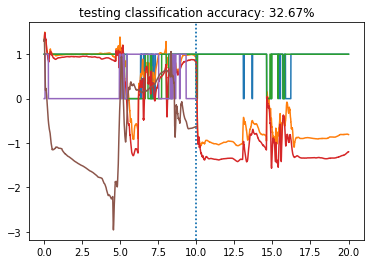

In [8]:
PatternInterpolationTrial().run(data_dir='debug')